In [1]:
from fastai2.vision.all import *
from fastai2.vision.core import _unscale_pnts
from effdet import get_efficientdet_config, EfficientDet, DetBenchTrain
from effdet.efficientdet import HeadNet
from effdet.anchors import Anchors,AnchorLabeler,generate_detections,MAX_DETECTION_POINTS
from effdet.loss import DetectionLoss

In [2]:
# refactor after testing 
# Setting up effdet related config

model_config = get_efficientdet_config('tf_efficientdet_d0')
model = EfficientDet(model_config,pretrained_backbone=True)
model_config.num_classes = 1
model_config.image_size = 256
model.class_net = HeadNet(model_config,num_outputs=model_config.num_classes,norm_kwargs=dict(eps=.001,momentum=0.01))
path = Path('/home/heye0507/wheat_detection/data')

In [3]:
# Fastai bbox style is [x1,y1,x2,y2], given coco-style is [x1,y1,w,h]
def convert_fastai_bbox(box):
    x1,y1,w,h = box
    x2 = x1 + w
    y2 = y1 + h
    return [x1,y1,x2,y2]
    
def prep_bbox(df):
    images, bbox = df['image_id'],df['bbox']
    d = collections.defaultdict(list)
    for i,b in zip(images,bbox):
        d[i].append(convert_fastai_bbox([float(i) for i in b[1:-1].split(',')]))
    return d

In [4]:
def get_data(path,sz=224,bs=64):
    base = Path(path).parent
    df = pd.read_csv(path)
    img2bbox = prep_bbox(df)
    dblocks = DataBlock(
        blocks = (ImageBlock,BBoxBlock,BBoxLblBlock),
        splitter = RandomSplitter(valid_pct=0.),
        get_x = lambda o: str(base/'train')+'/'+o+'.jpg',
        get_y = [lambda o: img2bbox[o], lambda o: ['wheat' for i in range(len(img2bbox[o]))]],
        item_tfms = Resize(sz),
        n_inp=1
    )
    return dblocks.dataloaders(img2bbox.keys(),bs=bs)

In [5]:
dls = get_data(path/'arvalis_1.csv',sz=256,bs=4)

In [6]:
b = dls.one_batch()
b[0].shape, b[1].shape, b[2].shape # img, bbox, bboxlbl

(torch.Size([4, 3, 256, 256]), torch.Size([4, 55, 4]), torch.Size([4, 55]))

# Initial merge effdet with fastai

In [7]:
def un_pad(boxes,labels):
    bb_keep = ((boxes[:,2] - boxes[:,0])>0).nonzero()[:,0]
    return boxes[bb_keep],labels[bb_keep]

In [8]:
# Setup anchor with gt_bbox & gt_lbl matching

anchors = Anchors(
    model_config.min_level,model_config.max_level,
    model_config.num_scales, model_config.aspect_ratios,
    model_config.anchor_scale, model_config.image_size
    )

# Test metrics

In [9]:
from numba import jit

In [57]:
# code from kaggle https://www.kaggle.com/pestipeti/competition-metric-details-script/data
@jit(nopython=True)
def calculate_iou(gt, pr, form='pascal_voc') -> float:
    """Calculates the Intersection over Union.

    Args:
        gt: (np.ndarray[Union[int, float]]) coordinates of the ground-truth box
        pr: (np.ndarray[Union[int, float]]) coordinates of the prdected box
        form: (str) gt/pred coordinates format
            - pascal_voc: [xmin, ymin, xmax, ymax]
            - coco: [xmin, ymin, w, h]
    Returns:
        (float) Intersection over union (0.0 <= iou <= 1.0)
    """
    if form == 'coco':
        gt = gt.copy()
        pr = pr.copy()

        gt[2] = gt[0] + gt[2]
        gt[3] = gt[1] + gt[3]
        pr[2] = pr[0] + pr[2]
        pr[3] = pr[1] + pr[3]

    # Calculate overlap area
    dx = min(gt[2], pr[2]) - max(gt[0], pr[0]) + 1
    
    if dx < 0:
        return 0.0
    
    dy = min(gt[3], pr[3]) - max(gt[1], pr[1]) + 1

    if dy < 0:
        return 0.0

    overlap_area = dx * dy

    # Calculate union area
    union_area = (
            (gt[2] - gt[0] + 1) * (gt[3] - gt[1] + 1) +
            (pr[2] - pr[0] + 1) * (pr[3] - pr[1] + 1) -
            overlap_area
    )

    return overlap_area / union_area

@jit(nopython=True)
def find_best_match(gts, pred, pred_idx, threshold = 0.5, form = 'pascal_voc', ious=None) -> int:
    """Returns the index of the 'best match' between the
    ground-truth boxes and the prediction. The 'best match'
    is the highest IoU. (0.0 IoUs are ignored).

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        pred: (List[Union[int, float]]) Coordinates of the predicted box
        pred_idx: (int) Index of the current predicted box
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (int) Index of the best match GT box (-1 if no match above threshold)
    """
    best_match_iou = -np.inf
    best_match_idx = -1

    for gt_idx in range(len(gts)):
        
        if gts[gt_idx][0] < 0:
            # Already matched GT-box
            continue
        
        iou = -1 if ious is None else ious[gt_idx][pred_idx]

        if iou < 0:
            iou = calculate_iou(gts[gt_idx], pred, form=form)
            
            if ious is not None:
                ious[gt_idx][pred_idx] = iou

        if iou < threshold:
            continue

        if iou > best_match_iou:
            best_match_iou = iou
            best_match_idx = gt_idx

    return best_match_idx

@jit(nopython=True)
def calculate_precision(gts, preds, threshold = 0.5, form = 'coco', ious=None) -> float:
    """Calculates precision for GT - prediction pairs at one threshold.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        threshold: (float) Threshold
        form: (str) Format of the coordinates
        ious: (np.ndarray) len(gts) x len(preds) matrix for storing calculated ious.

    Return:
        (float) Precision
    """
    n = len(preds)
    tp = 0
    fp = 0
    
    # for pred_idx, pred in enumerate(preds_sorted):
    for pred_idx in range(n):

        best_match_gt_idx = find_best_match(gts, preds[pred_idx], pred_idx,
                                            threshold=threshold, form=form, ious=ious)

        if best_match_gt_idx >= 0:
            # True positive: The predicted box matches a gt box with an IoU above the threshold.
            tp += 1
            # Remove the matched GT box
            gts[best_match_gt_idx] = -1

        else:
            # No match
            # False positive: indicates a predicted box had no associated gt box.
            fp += 1

    # False negative: indicates a gt box had no associated predicted box.
    fn = (gts.sum(axis=1) > 0).sum()

    return tp / (tp + fp + fn)


@jit(nopython=True)
def calculate_image_precision(gts, preds, thresholds = (0.5, ), form = 'coco') -> float:
    """Calculates image precision.

    Args:
        gts: (List[List[Union[int, float]]]) Coordinates of the available ground-truth boxes
        preds: (List[List[Union[int, float]]]) Coordinates of the predicted boxes,
               sorted by confidence value (descending)
        thresholds: (float) Different thresholds
        form: (str) Format of the coordinates

    Return:
        (float) Precision
    """
    n_threshold = len(thresholds)
    image_precision = 0.0
    
    ious = np.ones((len(gts), len(preds))) * -1
    # ious = None

    for threshold in thresholds:
        precision_at_threshold = calculate_precision(gts.copy(), preds, threshold=threshold,
                                                     form=form, ious=ious)
        image_precision += precision_at_threshold / n_threshold

    return image_precision

In [11]:
class myAnchorBox():
    def __init__(self,anchors,num_class,match_threshold=0.5):
        self.anchor_labeler = AnchorLabeler(anchors,num_class,match_threshold)

In [12]:
anchor_labeler = myAnchorBox(anchors,model_config.num_classes)

In [104]:
class TstLearner():
    def __init__(self): self.pred,self.y = None,None
        
#Go through a fake cycle with various batch sizes and computes the value of met
def compute_val(met, x1, x2):
    met.reset()
    learn = TstLearner()
    learn.pred,learn.y = x1,x2
    met.accumulate(learn)
    return met.value

In [97]:
test_mAP = partial(my_mAP,img_size=256)

In [99]:
from fastai2.metrics import AccumMetric

In [100]:
tst = AccumMetric(test_mAP)

In [105]:
test_close(compute_val(tst,preds,(b[1],b[2])),my_mAP(preds,(b[1],b[2])))

AttributeError: 'tuple' object has no attribute 'contiguous'

In [93]:
# Check caution lines and FIX it after testing

def my_mAP(preds,targs,img_size=256):
    class_out, box_out = preds
    gt_bbox, gt_lbl = targs
    batch_size = gt_bbox.shape[0]
    valid_img_precision = []
    
    
    ## unpack fastai2 collated batch
    boxes, labels = [],[]

    for i in range(batch_size):
        box, lbl = un_pad(gt_bbox[i],gt_lbl[i])
        box = _unscale_pnts(box,img_size).cpu()
        boxes.append(box.numpy()) 
        labels.append(lbl.float().cpu())
    ##########################################################
        
    ## prepare effDet format
    '''
        CAUTION: 
                model_config used as global var
                anchors used as global var
        
        res is a list of results in the format
        len(res) = MAX_DETECTION_POINTS, by default is 100, given dataset has max 116 bbox, suggests a higher num
        
        res: [[x,y,x,y,p,lbl],
              [],
              []...
             ]
        
        each of the item in res:
            0:4, bbox pred in xyxy pascal format
            5, confidence
            6, class (will always be 1. since only 1 class in the label)
                
        
    ''' 
    
    class_out,box_out,indices,classes = _post_process(model_config,class_out, box_out) # CAUTION
    res = _batch_detection(
        batch_size,class_out,
        box_out,anchors.boxes,
        indices,classes,
        tensor([1.]*batch_size),tensor([(img_size,img_size)]*batch_size)
    ) # CAUTION
    ##########################################################
        
    
    '''
        CAUTION:
                threshold and form is hardcode
    '''
    for i in range(batch_size):
        pred = res[i,:,0:4].detach().numpy() 
        valid_img_precision.append(calculate_precision(boxes[i],pred,threshold=0.5,form='pascal_voc')) # CAUTION
    return np.mean(valid_img_precision)
    

In [94]:
my_mAP(preds,(b[1],b[2]))

0.0

## Test one item in the batch

In [19]:
preds = learn.model(b[0])

In [60]:
cls_o, box_o = preds

AttributeError: 'tuple' object has no attribute 'detach'

In [21]:
box_o[1].shape

torch.Size([4, 36, 16, 16])

In [22]:
from effdet.bench import _post_process,_batch_detection

In [23]:
cls_o,box_o,indices,classes = _post_process(model_config,cls_o,box_o)

/opt/conda/conda-bld/pytorch_1587428111115/work/aten/src/ATen/native/BinaryOps.cpp:81: UserWarning: Integer division of tensors using div or / is deprecated, and in a future release div will perform true division as in Python 3. Use true_divide or floor_divide (// in Python) instead.


In [24]:
b[0].shape[2]

256

In [25]:
res = _batch_detection(4,cls_o,box_o,anchors.boxes,indices,classes,tensor([1.]*4),tensor([(256,256)]*4))

In [28]:
b[1].shape

torch.Size([4, 55, 4])

In [30]:
b[1][0].shape

torch.Size([55, 4])

In [35]:
box, lbl = un_pad(b[1][0],b[2][0])

In [36]:
box = _unscale_pnts(box,256)
box

TensorPoint([[  0.0000,   1.0000,  16.7500,  18.7500],
        [ 32.2500,  57.5000,  57.7500,  85.2500],
        [ 62.0000,  44.0000,  83.7500,  64.2500],
        [140.2500,  37.5000, 161.5000,  63.2500],
        [ 98.7500,  73.5000, 119.0000,  92.0000],
        [ 34.2500,  95.0000,  52.7500, 112.0000],
        [  8.0000,  91.0000,  23.0000, 108.2500],
        [ 23.2500, 118.7500,  39.7500, 137.0000],
        [ 39.2500, 119.2500,  58.5000, 137.5000],
        [103.0000, 113.2500, 131.0000, 136.7500],
        [135.7500, 101.5000, 157.0000, 119.7500],
        [148.0000,  80.0000, 168.5000,  96.2500],
        [160.0000, 101.5000, 182.2500, 121.0000],
        [210.7500, 108.7500, 240.7500, 125.5000],
        [241.2500,  88.7500, 256.0000, 102.2500],
        [232.2500,  33.2500, 256.0000,  54.5000],
        [189.2500,  34.0000, 210.5000,  54.7500],
        [177.2500, 139.0000, 214.0000, 164.0000],
        [126.0000, 154.5000, 171.0000, 179.7500],
        [102.5000, 174.0000, 132.0000, 194.25

In [53]:
box = box.numpy()

In [43]:
pred_t = res[0,:,:4].detach().numpy()

In [54]:
type(box),type(pred_t)

(numpy.ndarray, numpy.ndarray)

In [64]:
type(calculate_precision(box,pred_t,threshold=0.5, form='pascal_voc'))

float

## Ends Test one item in batch

In [27]:
res[0] # bbox in pascal (xyxy), confidence, class_lbl

tensor([[147.9213,  34.0022, 108.0787,  56.7162,   0.7491,   1.0000],
        [ 94.3752, 148.1128,  30.1446,  52.6194,   0.7312,   1.0000],
        [179.2300,  58.0780,  22.1936,  22.9427,   0.7218,   1.0000],
        [ 55.0045, 219.4999, 200.9955,  35.7155,   0.7169,   1.0000],
        [ 32.8208,  73.3128, 223.1792,  17.0515,   0.7130,   1.0000],
        [256.0000,  18.5512,   0.0000, 171.3965,   0.7006,   1.0000],
        [ 87.7732,  57.6122,  39.1776,  41.2651,   0.6964,   1.0000],
        [ 68.8620,  86.6201,  17.4454,  85.3198,   0.6962,   1.0000],
        [201.7247,  64.2280,  23.2171,  18.8281,   0.6960,   1.0000],
        [178.0925,  13.0822,  31.6233,  61.2273,   0.6914,   1.0000],
        [ 94.6772, 167.4801,  21.0064,  10.1315,   0.6914,   1.0000],
        [256.0000, 109.5852,   0.0000,  18.6028,   0.6912,   1.0000],
        [155.7521,  73.4414,  42.8729,   6.9292,   0.6884,   1.0000],
        [197.4418,  57.0413,  50.1744,  25.3051,   0.6860,   1.0000],
        [145.7589,  

In [26]:
res[0,:,:4]

tensor([[147.9213,  34.0022, 108.0787,  56.7162],
        [ 94.3752, 148.1128,  30.1446,  52.6194],
        [179.2300,  58.0780,  22.1936,  22.9427],
        [ 55.0045, 219.4999, 200.9955,  35.7155],
        [ 32.8208,  73.3128, 223.1792,  17.0515],
        [256.0000,  18.5512,   0.0000, 171.3965],
        [ 87.7732,  57.6122,  39.1776,  41.2651],
        [ 68.8620,  86.6201,  17.4454,  85.3198],
        [201.7247,  64.2280,  23.2171,  18.8281],
        [178.0925,  13.0822,  31.6233,  61.2273],
        [ 94.6772, 167.4801,  21.0064,  10.1315],
        [256.0000, 109.5852,   0.0000,  18.6028],
        [155.7521,  73.4414,  42.8729,   6.9292],
        [197.4418,  57.0413,  50.1744,  25.3051],
        [145.7589,  15.1986,  18.4057, 110.1019],
        [149.8547,   0.0000,  53.3798,   2.9385],
        [235.3934,  25.6261,  20.6066,  35.7220],
        [247.0399,   0.0000,   8.9601,  68.9039],
        [152.0358,  63.5969,  75.4350, 147.4398],
        [210.6731,  48.8145,  26.6590, 135.9900],


In [75]:
tensor([1]*4)[0], tensor([(256,256)]*4)[0] # img_scale, img_size format

(tensor(1), tensor([256, 256]))

In [76]:
s = torch.tensor(1)
i_s = torch.tensor([256,256])

In [77]:
torch.cat([i_s/s,i_s/s],dim=0)

tensor([256, 256, 256, 256])

# End Test metrics

In [17]:
def Effdet_Loss(preds, *targets):
    class_out, box_out = preds
    gt_bbox, gt_lbl = targets
    batch_sz = gt_bbox.shape[0]
    anchor_labeler = AnchorLabeler(anchors, model_config.num_classes,match_threshold=0.5)
    loss_func = DetectionLoss(model_config)

    # unpack fastai2 collated batch
    boxes, labels = [],[]
    perm = torch.LongTensor([1,0,3,2])

    # Effdet loss function looking for list of tensors, 
    '''
        batch_label_anchors
            batch size
            list of bounding box
            list of label (float)
    '''
    # can this part of code using broadcasting? 
    # currently after unpad they don't have same size
    # if unscale batchwise then un_pad, will have 128,128,128,128 needs to be removed itemwises.

    for i in range(batch_sz):
        box, lbl = un_pad(gt_bbox[i],gt_lbl[i])
        boxes.append(_unscale_pnts(box[:,perm],256).cpu()) # to tf style, yxyx
        labels.append(lbl.float().cpu())

    # match anchors to gt_bbox and gt_lbl

    cls_targets, box_targets, num_positivies = anchor_labeler.batch_label_anchors(
        batch_sz, boxes, labels
        )
    if torch.cuda.is_avaiable():
        for i in range(len(cls_targets)):
            cls_targets[i] = cls_targets[i].cuda()
            box_targets[i] = box_targets[i].cuda()
    loss, class_loss, box_loss = loss_func(class_out, box_out, cls_targets, box_targets, num_positivies)
    return loss



In [18]:
learn = Learner(dls,model,loss_func=Effdet_Loss,model_dir='/home/heye0507/wheat_detection/model/')

In [20]:
# learn.summary()

SuggestedLRs(lr_min=0.006918309628963471, lr_steep=0.05754399299621582)

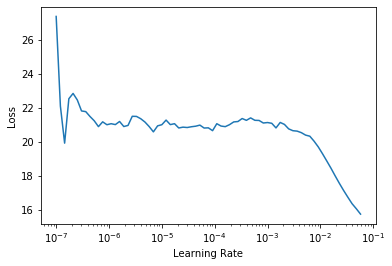

In [34]:
learn.lr_find()